## 参考资料
- https://github.com/fg91/visualizing-cnn-feature-maps
- https://towardsdatascience.com/how-to-visualize-convolutional-features-in-40-lines-of-code-70b7d87b0030

## 导入相应的库

In [1]:
import torch
from torch.autograd import Variable
from PIL import Image,ImageOps
import torchvision.transforms as transforms
import torchvision.models as models

import numpy as np
import cv2
from cv2 import resize
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

## 初始化图片

In [3]:
# 生成随机的图片
sz = 56
img = np.uint8(np.random.uniform(150, 180, (3, sz, sz)))/255
img = torch.from_numpy(img[None]).float().to(device)
# img[None]可以增加一个维度
# img_var = Variable(torch.from_numpy(img[None]).float().to(device), requires_grad=True) # 转换为pytorch的变量, 需要梯度
# img_var.shape
img.shape

torch.Size([1, 3, 56, 56])

## 给出一个预训练好的网络

In [4]:
model_vgg16 = models.vgg16_bn(pretrained=True).features.to(device).eval()

In [5]:
len(list(model_vgg16.children()))

44

In [5]:
list(model_vgg16.children())

[Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
 ReLU(inplace),
 Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
 ReLU(inplace),
 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
 Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
 ReLU(inplace),
 Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
 ReLU(inplace),
 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
 Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
 ReLU(inplace),
 Conv2d(2

## 注册hook,进行正向传播,计算梯度,找到最优图片

In [6]:
class SaveFeatures():
    """注册hook和移除hook
    """
    def __init__(self, module):
        self.hook = module.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output):
        # self.features = output.clone().detach().requires_grad_(True)
        self.features = output.clone()
    def close(self):
        self.hook.remove()

In [7]:
# 将hook注册在倒数第三层
layer = 40
activations = SaveFeatures(list(model_vgg16.children())[layer])

### 反向传播, 找到最优的图片

In [8]:
# 超参数
lr = 0.1 # 学习率
opt_steps = 25 # 迭代次数
filters = 265 # 第265个filter,使其最大
upscaling_steps = 13 # 图像放大次数
blur=3
upscaling_factor=1.2 # 把图像变粗

# 定义处理时的均值与方差
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).view(-1, 1, 1).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).view(-1, 1, 1).to(device)


for epoch in range(upscaling_steps):  # scale the image up upscaling_steps times
    # --------------------------------------------------------------------------------
    # 因为原始的VGG网络对图片做了normalization, 所以这里对输入图片也要做normalization
    # --------------------------------------------------------------------------------
    img = (img - cnn_normalization_mean) / cnn_normalization_std
    img[img>1]=1
    img[img<0]=0
    print('Imgshape1 : ',img.shape)
    img_var = Variable(img, requires_grad=True)  # convert image to Variable that requires grad
    # ----------
    # 定义优化器
    # ----------
    optimizer = torch.optim.Adam([img_var], lr=lr, weight_decay=1e-6)
    for n in range(opt_steps):  # optimize pixel values for opt_steps times
        optimizer.zero_grad()
        model_vgg16(img_var) # 正向传播
        loss = -activations.features[0, filters].mean() # loss相当于最大该层的激活的值
        loss.backward()
        optimizer.step()
    # ------------
    # 图像进行还原
    # ------------
    print('Loss:',loss.cpu().detach().numpy())
    img = img_var * cnn_normalization_std + cnn_normalization_mean # 这个使用img_var变换img
    img[img>1]=1
    img[img<0]=0
    img = img.data.cpu().numpy()[0].transpose(1,2,0)
    sz = int(upscaling_factor * sz)  # calculate new image size
    img = cv2.resize(img, (sz, sz), interpolation = cv2.INTER_CUBIC)  # scale image up
    if blur is not None: img = cv2.blur(img,(blur,blur))  # blur image to reduce high frequency patterns
    print('Imgshape2 : ',img.shape)
    img = torch.from_numpy(img.transpose(2,0,1)[None]).to(device)
    print('Imgshape3 : ',img.shape)
    print(str(epoch),',Finished')
    print('=======')

activations.close() # 移除hook

# 保存图片
image = img.cpu().clone()
image = image.squeeze(0)
unloader = transforms.ToPILImage()

image = unloader(image)
image = cv2.cvtColor(np.asarray(image),cv2.COLOR_RGB2BGR) 
cv2.imwrite('res1.jpg',image)
torch.cuda.empty_cache()

Imgshape1 :  torch.Size([1, 3, 56, 56])
Loss: -6.7902794
Imgshape2 :  (67, 67, 3)
Imgshape3 :  torch.Size([1, 3, 67, 67])
0 ,Finished
Imgshape1 :  torch.Size([1, 3, 67, 67])
Loss: -8.646091
Imgshape2 :  (80, 80, 3)
Imgshape3 :  torch.Size([1, 3, 80, 80])
1 ,Finished
Imgshape1 :  torch.Size([1, 3, 80, 80])
Loss: -9.490366
Imgshape2 :  (96, 96, 3)
Imgshape3 :  torch.Size([1, 3, 96, 96])
2 ,Finished
Imgshape1 :  torch.Size([1, 3, 96, 96])
Loss: -10.114728
Imgshape2 :  (115, 115, 3)
Imgshape3 :  torch.Size([1, 3, 115, 115])
3 ,Finished
Imgshape1 :  torch.Size([1, 3, 115, 115])
Loss: -10.062547
Imgshape2 :  (138, 138, 3)
Imgshape3 :  torch.Size([1, 3, 138, 138])
4 ,Finished
Imgshape1 :  torch.Size([1, 3, 138, 138])
Loss: -10.0085125
Imgshape2 :  (165, 165, 3)
Imgshape3 :  torch.Size([1, 3, 165, 165])
5 ,Finished
Imgshape1 :  torch.Size([1, 3, 165, 165])
Loss: -9.711624
Imgshape2 :  (198, 198, 3)
Imgshape3 :  torch.Size([1, 3, 198, 198])
6 ,Finished
Imgshape1 :  torch.Size([1, 3, 198, 198])


## 总体的代码

In [13]:
torch.cuda.empty_cache()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 生成随机的图片
sz = 56
img = np.uint8(np.random.uniform(150, 180, (3, sz, sz)))/255
img = torch.from_numpy(img[None]).float().to(device)
# img[None]可以增加一个维度
# img_var = Variable(torch.from_numpy(img[None]).float().to(device), requires_grad=True) # 转换为pytorch的变量, 需要梯度
# img_var.shape

model_vgg16 = models.vgg16_bn(pretrained=True).features.to(device).eval()

# 将hook注册在倒数第三层
layer = 40
activations = SaveFeatures(list(model_vgg16.children())[layer])

# 超参数
lr = 0.1 # 学习率
opt_steps = 25 # 迭代次数
filters = 265 # 第265个filter,使其最大
upscaling_steps = 13 # 图像反复迭代次数
blur=3
upscaling_factor=1.2 # 把图像变粗

# 定义处理时的均值与方差
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).view(-1, 1, 1).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).view(-1, 1, 1).to(device)


for epoch in range(upscaling_steps):  # scale the image up upscaling_steps times
    # --------------------------------------------------------------------------------
    # 因为原始的VGG网络对图片做了normalization, 所以这里对输入图片也要做normalization
    # --------------------------------------------------------------------------------
    img = (img - cnn_normalization_mean) / cnn_normalization_std
    img[img>1]=1
    img[img<0]=0
    print('Imgshape1 : ',img.shape)
    img_var = Variable(img, requires_grad=True)  # convert image to Variable that requires grad
    # ----------
    # 定义优化器
    # ----------
    optimizer = torch.optim.Adam([img_var], lr=lr, weight_decay=1e-6)
    for n in range(opt_steps):  # optimize pixel values for opt_steps times
        optimizer.zero_grad()
        model_vgg16(img_var) # 正向传播
        loss = -activations.features[0, filters].mean() # loss相当于最大该层的激活的值
        loss.backward()
        optimizer.step()
    # ------------
    # 图像进行还原
    # ------------
    print('Loss:',loss.cpu().detach().numpy())
    img = img_var * cnn_normalization_std + cnn_normalization_mean # 这个使用img_var变换img
    img[img>1]=1
    img[img<0]=0
    img = img.data.cpu().numpy()[0].transpose(1,2,0)
    sz = int(upscaling_factor * sz)  # calculate new image size
    img = cv2.resize(img, (sz, sz), interpolation = cv2.INTER_CUBIC)  # scale image up
    if blur is not None: img = cv2.blur(img,(blur,blur))  # blur image to reduce high frequency patterns
    print('Imgshape2 : ',img.shape)
    img = torch.from_numpy(img.transpose(2,0,1)[None]).to(device)
    print('Imgshape3 : ',img.shape)
    print(str(epoch),',Finished')
    print('=======')

activations.close() # 移除hook

image = img.cpu().clone()
image = image.squeeze(0)
unloader = transforms.ToPILImage()

image = unloader(image)
image = cv2.cvtColor(np.asarray(image),cv2.COLOR_RGB2BGR) 
cv2.imwrite('res1.jpg',image)
torch.cuda.empty_cache()

Imgshape1 :  torch.Size([1, 3, 56, 56])
Loss: -5.5001235
Imgshape2 :  (67, 67, 3)
Imgshape3 :  torch.Size([1, 3, 67, 67])
0 ,Finished
Imgshape1 :  torch.Size([1, 3, 67, 67])
Loss: -7.377492
Imgshape2 :  (80, 80, 3)
Imgshape3 :  torch.Size([1, 3, 80, 80])
1 ,Finished
Imgshape1 :  torch.Size([1, 3, 80, 80])
Loss: -7.718061
Imgshape2 :  (96, 96, 3)
Imgshape3 :  torch.Size([1, 3, 96, 96])
2 ,Finished
Imgshape1 :  torch.Size([1, 3, 96, 96])
Loss: -7.2772813
Imgshape2 :  (115, 115, 3)
Imgshape3 :  torch.Size([1, 3, 115, 115])
3 ,Finished
Imgshape1 :  torch.Size([1, 3, 115, 115])
Loss: -7.0601907
Imgshape2 :  (138, 138, 3)
Imgshape3 :  torch.Size([1, 3, 138, 138])
4 ,Finished
Imgshape1 :  torch.Size([1, 3, 138, 138])
Loss: -6.1325536
Imgshape2 :  (165, 165, 3)
Imgshape3 :  torch.Size([1, 3, 165, 165])
5 ,Finished
Imgshape1 :  torch.Size([1, 3, 165, 165])
Loss: -5.674845
Imgshape2 :  (198, 198, 3)
Imgshape3 :  torch.Size([1, 3, 198, 198])
6 ,Finished
Imgshape1 :  torch.Size([1, 3, 198, 198])
L

## 验证自己的猜想

In [1]:
import torch
from torch.autograd import Variable
from PIL import Image
import torchvision.transforms as transforms
import torchvision.models as models

import numpy as np
import cv2
from cv2 import resize
from matplotlib import pyplot as plt
%matplotlib inline

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class SaveFeatures():
    """注册hook和移除hook
    """
    def __init__(self, module):
        self.hook = module.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output):
        # self.features = output.clone().detach().requires_grad_(True)
        self.features = output.clone()
    def close(self):
        self.hook.remove()

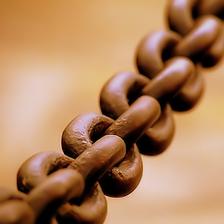

In [9]:
# 导入图片
size = (224, 224)
picture = Image.open("./Broad_chain_closeup.jpg")
# picture = Image.open("./Wattledcranethumb.jpg")
picture = ImageOps.fit(picture, size, Image.ANTIALIAS)
picture

In [20]:
picture.size

(224, 224)

In [10]:
# 导入图像
loader = transforms.ToTensor()
picture = loader(picture).to(device)
picture.shape

torch.Size([3, 224, 224])

In [22]:
picture

tensor([[[0.4353, 0.4353, 0.4392,  ..., 0.4235, 0.4157, 0.4118],
         [0.4353, 0.4353, 0.4392,  ..., 0.4275, 0.4157, 0.4157],
         [0.4314, 0.4314, 0.4353,  ..., 0.4196, 0.4235, 0.4196],
         ...,
         [0.2118, 0.2784, 0.3451,  ..., 0.2471, 0.2235, 0.2275],
         [0.2471, 0.2980, 0.3176,  ..., 0.2235, 0.2078, 0.2392],
         [0.3216, 0.3294, 0.3098,  ..., 0.2196, 0.2510, 0.2941]],

        [[0.4549, 0.4549, 0.4588,  ..., 0.4510, 0.4549, 0.4588],
         [0.4549, 0.4549, 0.4588,  ..., 0.4549, 0.4549, 0.4549],
         [0.4510, 0.4510, 0.4549,  ..., 0.4588, 0.4549, 0.4510],
         ...,
         [0.2039, 0.2392, 0.2902,  ..., 0.2353, 0.1882, 0.1725],
         [0.2431, 0.2627, 0.2588,  ..., 0.2039, 0.1608, 0.1686],
         [0.3294, 0.3098, 0.2549,  ..., 0.1882, 0.1922, 0.2157]],

        [[0.4275, 0.4275, 0.4314,  ..., 0.4235, 0.4235, 0.4196],
         [0.4275, 0.4275, 0.4314,  ..., 0.4235, 0.4196, 0.4118],
         [0.4235, 0.4235, 0.4275,  ..., 0.4196, 0.4118, 0.

In [11]:
# 将图片做标准化, 转换为vgg网络的输入
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).view(-1, 1, 1).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).view(-1, 1, 1).to(device)
# 减均值. 除方差
picture = (picture - cnn_normalization_mean) / cnn_normalization_std
# 查看转换之后的效果
# unload = transforms.ToPILImage()
# unload(picture.cpu())

In [14]:
list(model_vgg16.children())[42]

ReLU(inplace)

In [15]:
# 定义网络
model_vgg16 = models.vgg16_bn(pretrained=True).features.to(device).eval()
# 对网络进行hook,hook住指定层的output的值
layer = 42 # 这里是ReLU之后, 经过激活之后也应该较大
filters = 265
activations = SaveFeatures(list(model_vgg16.children())[layer])
# 网络前向传播
with torch.no_grad():
    picture_var = Variable(picture[None])
    model_vgg16(picture_var)
activations.close() # 移除hook

In [8]:
# 一共512个filter, 每个的输出大小为37*50
activations.features.shape

torch.Size([1, 512, 37, 50])

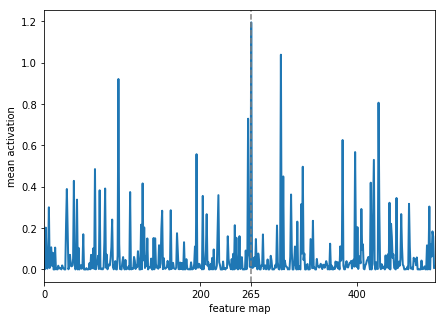

In [16]:
# 画出每个filter的平均值
mean_act = [activations.features[0,i].mean().item() for i in range(512)] # 计算平均值

plt.figure(figsize=(7,5))
act = plt.plot(mean_act,linewidth=2.) # 画出折线图
extraticks=[filters] # 增加的一个坐标
ax = act[0].axes
ax.set_xlim(0,500)
plt.axvline(x=filters, color='grey', linestyle='--') # 绘制虚线
ax.set_xlabel("feature map")
ax.set_ylabel("mean activation")
ax.set_xticks([0,200,400] + extraticks)
plt.show()

In [10]:
# 找出比较大的filter
thresh = 0.35
[i for i in range(512) if mean_act[i]>thresh]

[71]